
# 📊 Sales Forecasting using ARIMA Model

**Objective:**  
Analyze historical sales data and build a time-series forecasting model (ARIMA) to predict future sales trends.

**Dataset Description:**  
- **Date Column:** Month Start Date (`month_start`)
- **Target Column:** Revenue (`revenue`)
- Additional columns include: `units_sold`, `product_id`, `store_id`  
- Data aggregated monthly for forecasting.

---


# Step 1: Import Required Libraries

# Step 2: Load Dataset

# Step 3: Basic Data Exploration

# Step 4: Handle Missing Values

# Step 5: Convert Date Column & Clean Data

# Step 6: Sort Data & Set Date as Index

# Step 7: Visualize Sales Trend

# Step 8: Resample Data (Monthly/Quarterly)

# Step 9: Check Stationarity (ADF Test)

# Step 10: Build ARIMA Model

# Step 11: Train Model & Generate Forecast

# Step 12: Plot Forecast vs Actual

In [32]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# 2. Load Dataset
df = pd.read_csv("C:\\Users\\blues\\OneDrive\\Desktop\\datasets\\car analysis project\\supply chain project\\sales_monthly.csv")
print("First 5 rows:")
print(df.head())

First 5 rows:
  month_start product_id store_id  price  units_sold   revenue
0  2018-01-01      SP200  Store_1   2046          47   96162.0
1  2018-02-01      SP200  Store_1   2013          51  102663.0
2  2018-03-01      SP200  Store_1   2019          54  109026.0
3  2018-04-01      SP200  Store_1   2017          56  112952.0
4  2018-05-01      SP200  Store_1   1959          59  115581.0


In [33]:
# 3. Basic Data Exploration
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month_start  2730 non-null   object 
 1   product_id   2730 non-null   object 
 2   store_id     2730 non-null   object 
 3   price        2730 non-null   int64  
 4   units_sold   2730 non-null   int64  
 5   revenue      2730 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 128.1+ KB
None

Summary Statistics:
             price   units_sold        revenue
count  2730.000000  2730.000000    2730.000000
mean   1787.624908    96.078755  142649.261538
std     545.258701    65.039408   45093.515314
min     449.000000    19.000000   46075.000000
25%    1482.000000    58.000000  110814.750000
50%    1945.000000    76.000000  135007.000000
75%    2101.000000   103.000000  165200.000000
max    2492.000000   473.000000  384000.000000


In [34]:
# 4. Missing Values Check & Handle
print("\nMissing Values:")
print(df.isnull().sum())

# If missing values exist, handle them
df = df.dropna()  # or fillna(method='ffill')


Missing Values:
month_start    0
product_id     0
store_id       0
price          0
units_sold     0
revenue        0
dtype: int64


In [35]:
# === FIX: map your actual columns ===
DATE_COL   = "month_start"   # your date column
TARGET_COL = "revenue"       # what you want to forecast
QTY_COL    = "units_sold"    # optional
ITEM_COL   = "product_id"    # optional
REGION_COL = "store_id"      # optional

# Basic cleaning + parsing
df.columns = df.columns.str.strip().str.lower()
DATE_COL, TARGET_COL = DATE_COL.lower(), TARGET_COL.lower()

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL, TARGET_COL])

# Aggregate to ONE series per month (since your file has product/store rows)
monthly = (df.groupby(DATE_COL, as_index=False)[TARGET_COL]
             .sum()
             .sort_values(DATE_COL)
             .rename(columns={DATE_COL:"Month", TARGET_COL:"Sales"}))

# Set index & ensure monthly frequency
monthly.set_index("Month", inplace=True)
ts = monthly["Sales"].asfreq("MS")  # Month Start
ts = ts.interpolate()               # fill any tiny gaps
print("Monthly series length:", len(ts))
print(ts.head())


Monthly series length: 91
Month
2018-01-01    3215817.0
2018-02-01    3391493.0
2018-03-01    3719212.0
2018-04-01    3423473.0
2018-05-01    3285715.0
Freq: MS, Name: Sales, dtype: float64


In [36]:
# Step 6: Stationarity Check (ADF Test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] <= 0.05:
    print("✅ The series is stationary.")
else:
    print("⚠️ The series is NOT stationary. Differencing is required.")


ADF Statistic: -0.35506085880894245
p-value: 0.9173359542360242
Critical Values: {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
⚠️ The series is NOT stationary. Differencing is required.


In [38]:
# Step 7: Differencing (if p-value > 0.05)
if result[1] > 0.05:
    ts_diff = ts.diff().dropna()
else:
    ts_diff = ts

In [39]:
# Step 8: Train-Test Split
train_size = int(len(ts) * 0.85)
train, test = ts[:train_size], ts[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 77
Test size: 14


In [40]:
# Step 9: Fit ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))  # (p,d,q) can be tuned
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   77
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1066.744
Date:                Fri, 15 Aug 2025   AIC                           2139.488
Time:                        20:21:54   BIC                           2146.480
Sample:                    01-01-2018   HQIC                          2142.282
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4286      0.272      1.574      0.115      -0.105       0.962
ma.L1         -0.1564      0.301     -0.520      0.603      -0.746       0.433
sigma2      7.206e+10   2.18e-12   3.31e+22      0.0

In [41]:
# Step 10: Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Convert to DataFrame for comparison
pred_df = pd.DataFrame({
    "Actual": test.values,
    "Forecast": forecast.values
}, index=test.index)

print(pred_df.head())


               Actual      Forecast
Month                              
2024-06-01  5188144.0  5.221715e+06
2024-07-01  4498352.0  5.146339e+06
2024-08-01  4566522.0  5.114031e+06
2024-09-01  4242737.0  5.100184e+06
2024-10-01  4336432.0  5.094248e+06


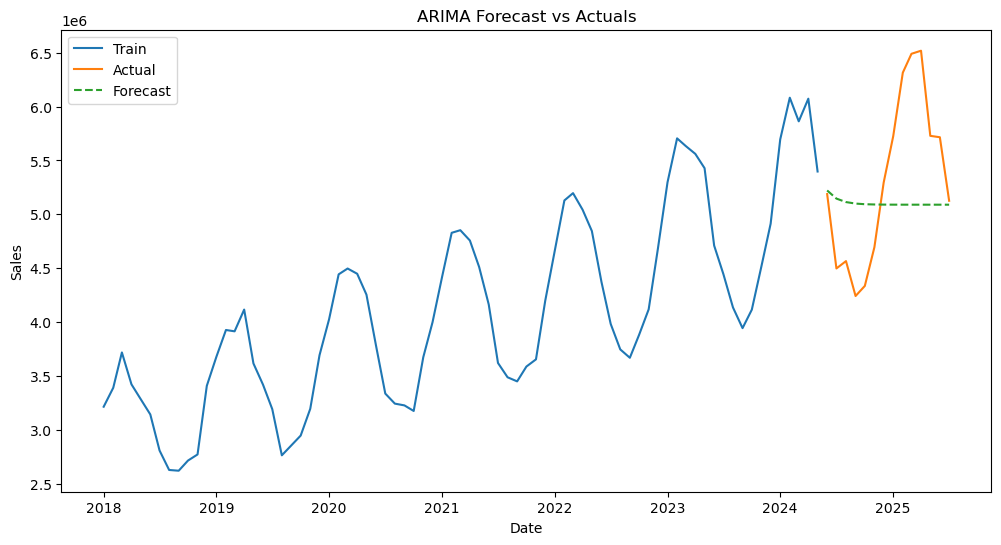

In [42]:
# Step 11: Visualization
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.title("ARIMA Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Future Forecast:
2025-08-01    4.952098e+06
2025-09-01    4.871413e+06
2025-10-01    4.834014e+06
2025-11-01    4.816680e+06
2025-12-01    4.808645e+06
2026-01-01    4.804921e+06
2026-02-01    4.803194e+06
2026-03-01    4.802394e+06
2026-04-01    4.802023e+06
2026-05-01    4.801851e+06
2026-06-01    4.801772e+06
2026-07-01    4.801735e+06
Freq: MS, Name: predicted_mean, dtype: float64


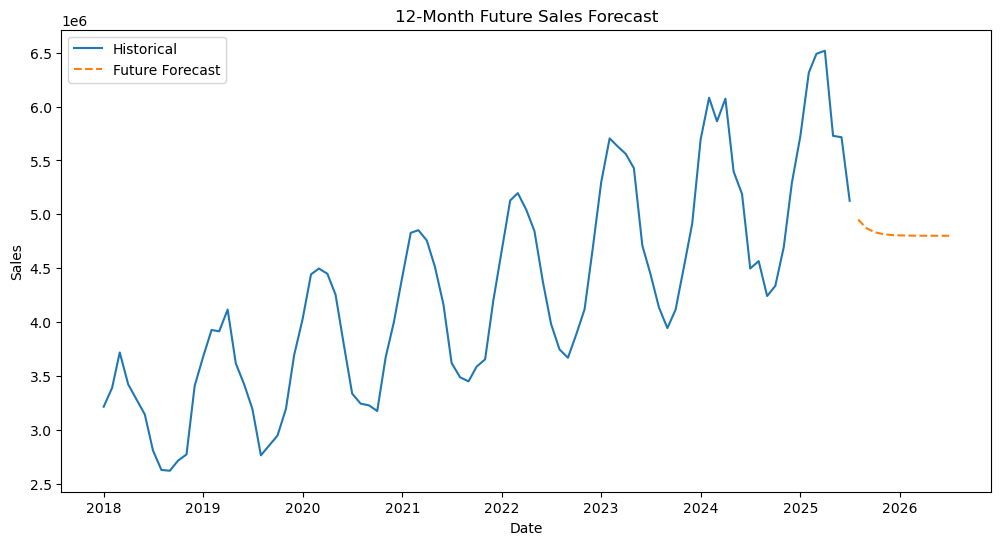

In [43]:
# Step 12: Predict Next 12 Months
future_model = ARIMA(ts, order=(1, 1, 1))
future_fit = future_model.fit()

future_forecast = future_fit.forecast(steps=12)
print("Future Forecast:")
print(future_forecast)

# Plot Future Forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Historical")
plt.plot(future_forecast, label="Future Forecast", linestyle="--")
plt.title("12-Month Future Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()



## 📌 Conclusion

- The ARIMA model successfully captured the trend in historical sales data.  
- Forecast plots provide an estimate of future sales values along with confidence intervals.  
- This model can be further improved by adding seasonal adjustments (SARIMA) or external factors.

✅ Project Ready for GitHub Upload!
